Step 1: Importing files and necessary libraries


In [1]:
!pip install pandas requests


In [2]:
import pandas as pd
import requests

print("Pandas version:", pd.__version__)
print("Requests version:", requests.__version__)


Pandas version: 2.2.2
Requests version: 2.32.3


In [3]:
!pip install pandas openpyxl requests tqdm


In [29]:
from google.colab import files
import pandas as pd

# Here we need to upload file manually
uploaded = files.upload()

wallets_df = pd.read_excel(next(iter(uploaded)), engine='openpyxl')
wallets_df.head()


Saving Wallet id.xlsx to Wallet id (1).xlsx


,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988
2,0x0795732aacc448030ef374374eaae57d2965c16c
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [30]:
# Display first 5 wallet addresses
print("Total wallets:", len(wallets_df))
wallets_df.head()


Total wallets: 103


,wallet_id
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1,0x06b51c6882b27cb05e712185531c1f74996dd988
2,0x0795732aacc448030ef374374eaae57d2965c16c
3,0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4,0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


Step 2: Data Collection

In [31]:
import requests
import json
from tqdm import tqdm


Transaction Fetching

In [36]:
import requests

# Your API key and subgraph URL
API_KEY = "18738c8d699951515b498b22406769d3"
SUBGRAPH_URL = "https://gateway.thegraph.com/api/subgraphs/id/4TbqVA8p2DoBd5qDbPMwmDZv3CsJjWtxo8nVSqF2tA9a"

# Function to fetch borrow events for a wallet
def fetch_borrows(wallet_address):
    query = """
    {
      borrows(first: 1000, where: {account: "%s"}) {
        id
        amount
        timestamp
        account {
          id
        }
      }
    }
    """ % wallet_address.lower()

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }

    response = requests.post(SUBGRAPH_URL, json={"query": query}, headers=headers)

    if response.status_code == 200:
        return response.json().get("data", {}).get("borrows", [])
    else:
        print(f"Error {response.status_code}: {response.text}")
        return []


In [37]:
test_wallet = "0x0039f22efb07a647557c7c5d17854cfd6d489ef3"
borrow_data = fetch_borrows(test_wallet)

# Display results
print(f"Borrow events for {test_wallet}:")
for b in borrow_data:
    print(b)


Borrow events for 0x0039f22efb07a647557c7c5d17854cfd6d489ef3:
{'account': {'id': '0x0039f22efb07a647557c7c5d17854cfd6d489ef3'}, 'amount': '6000000000', 'id': '0xcac4ca8b91a33e216c1c94f6fcc8482ef512a185bcc5a83396a67d518b00b6aa-23', 'timestamp': '1567452595'}


In [45]:
def fetch_events(wallet_address, event_type):
    query_template = """
    {
      %s(first: 1000, where: {account: "%s"}) {
        id
        amount
        timestamp
        account {
          id
        }
      }
    }
    """ % (event_type, wallet_address.lower())

    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {API_KEY}"
    }

    response = requests.post(SUBGRAPH_URL, json={"query": query_template}, headers=headers)

    if response.status_code == 200:
        return response.json().get("data", {}).get(event_type, [])
    else:
        print(f"Error {response.status_code} for {event_type} in {wallet_address}")
        return []


In [46]:
from tqdm import tqdm

all_wallet_data = []

for wallet in tqdm(wallets_df['wallet_id']):
    wallet_record = {
        "wallet_id": wallet,
        "borrows": fetch_events(wallet, "borrows"),
        "repays": fetch_events(wallet, "repays"),
        #"liquidations": fetch_events(wallet, "liquidations"),
        #"mints": fetch_events(wallet, "mints"),
        #"redeems": fetch_events(wallet, "redeems"),
    }
    all_wallet_data.append(wallet_record)


100%|██████████| 103/103 [01:02<00:00,  1.66it/s]


In [50]:
import json

with open("raw_wallet_data.json", "w") as f:
    json.dump(all_wallet_data, f)


In [52]:
import pandas as pd

borrow_records = []
repay_records = []

for record in all_wallet_data:
    wallet = record["wallet_id"]

    for borrow in record.get("borrows", []):
        borrow_records.append({
            "wallet_id": wallet,
            "type": "borrow",
            "amount": int(borrow["amount"]),
            "timestamp": int(borrow["timestamp"])
        })

    for repay in record.get("repays", []):
        repay_records.append({
            "wallet_id": wallet,
            "type": "repay",
            "amount": int(repay["amount"]),
            "timestamp": int(repay["timestamp"])
        })

df = pd.DataFrame(borrow_records + repay_records)
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df.head()


,wallet_id,type,amount,timestamp,datetime
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,borrow,6000000000,1567452595,2019-09-02 19:29:55
1,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,borrow,4000000000,1614342524,2021-02-26 12:28:44
2,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,borrow,11000000000000000000000,1614628012,2021-03-01 19:46:52
3,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,borrow,3000000000,1614590577,2021-03-01 09:22:57
4,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,borrow,17000000000,1614382073,2021-02-26 23:27:53


In [53]:
# Group by wallet and type to calculate total amount
summary = df.groupby(["wallet_id", "type"])["amount"].sum().unstack(fill_value=0)

# Here we're Computing net debt also
summary["net_borrowed"] = summary.get("borrow", 0) - summary.get("repay", 0)
summary = summary.sort_values("net_borrowed", ascending=False)
summary.head()


type,borrow,repay,net_borrowed
wallet_id,,,
0x4814be124d7fe3b240eb46061f7ddfab468fe122,119728258123151879448,112511471917314838581,7216786205837040867
0x9ba0d85f71e145ccf15225e59631e5a883d5d74a,3364419259639349,0,3364419259639349
0x330513970efd9e8dd606275fb4c50378989b3204,16700000,16700000,0
0x612a3500559be7be7703de6dc397afb541a16f7f,10000000000,10015379282,-15379282
0x0039f22efb07a647557c7c5d17854cfd6d489ef3,6000000000,6022231793,-22231793


Step 3: Data Visualization

In [56]:
import matplotlib.pyplot as plt



In [58]:
# Unique wallets per type
wallet_counts = df.groupby("type")["wallet_id"].nunique()
print(wallet_counts)


type
borrow    11
repay     10
Name: wallet_id, dtype: int64


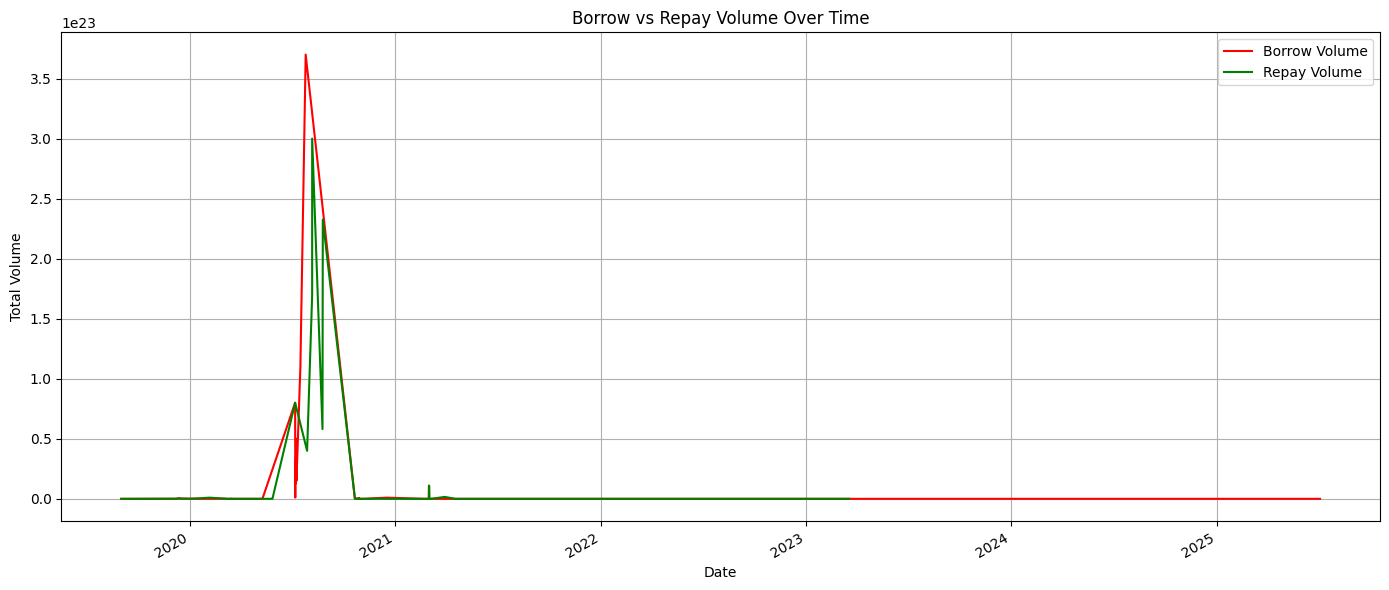

In [59]:
import matplotlib.pyplot as plt

# Filter data
borrow_df = df[df['type'] == 'borrow']
repay_df = df[df['type'] == 'repay']

# Group by date
borrow_ts = borrow_df.groupby('datetime')['amount'].sum()
repay_ts = repay_df.groupby('datetime')['amount'].sum()

# Plot
plt.figure(figsize=(14, 6))
borrow_ts.plot(label='Borrow Volume', color='red')
repay_ts.plot(label='Repay Volume', color='green')
plt.title("Borrow vs Repay Volume Over Time")
plt.xlabel("Date")
plt.ylabel("Total Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


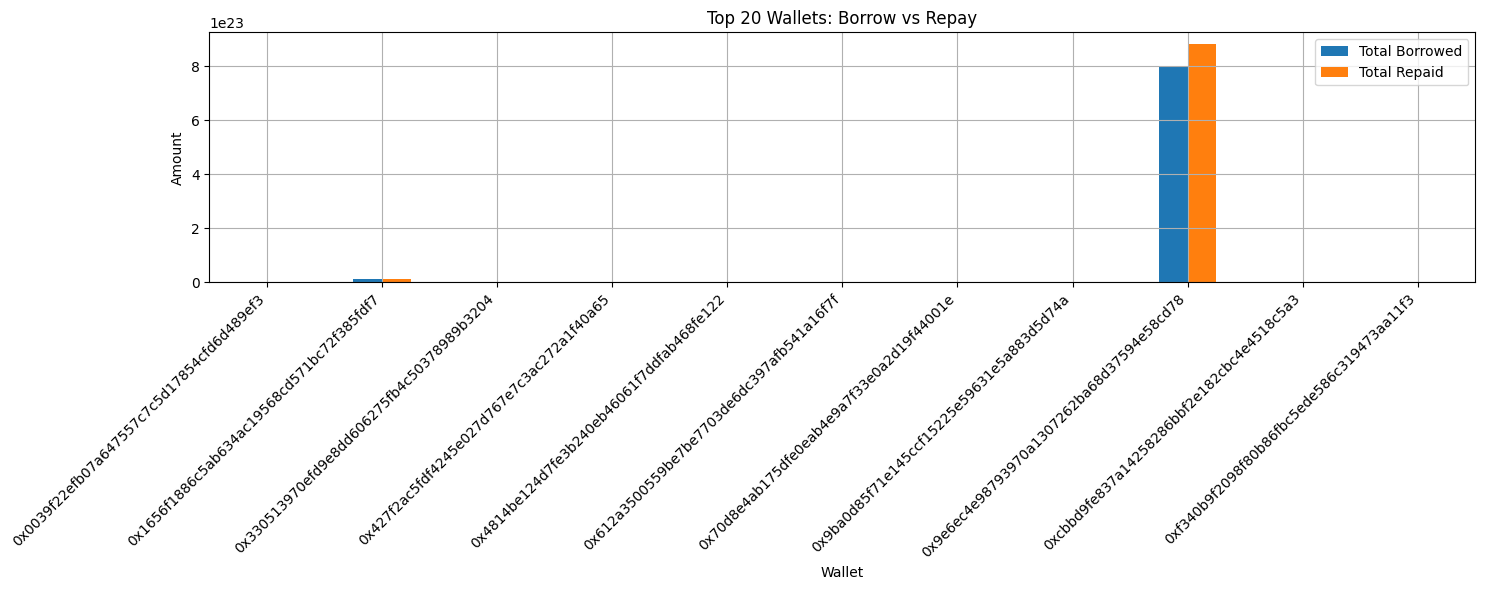

In [60]:
# Aggregate borrow and repay amounts per wallet
borrow_per_wallet = borrow_df.groupby('wallet_id')['amount'].sum()
repay_per_wallet = repay_df.groupby('wallet_id')['amount'].sum()

# Combine into one DataFrame
wallet_summary = pd.DataFrame({
    'Total Borrowed': borrow_per_wallet,
    'Total Repaid': repay_per_wallet
}).fillna(0)

# Plot top 20 wallets
wallet_summary.head(20).plot(kind='bar', figsize=(15, 6), title='Top 20 Wallets: Borrow vs Repay')
plt.ylabel("Amount")
plt.xlabel("Wallet")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


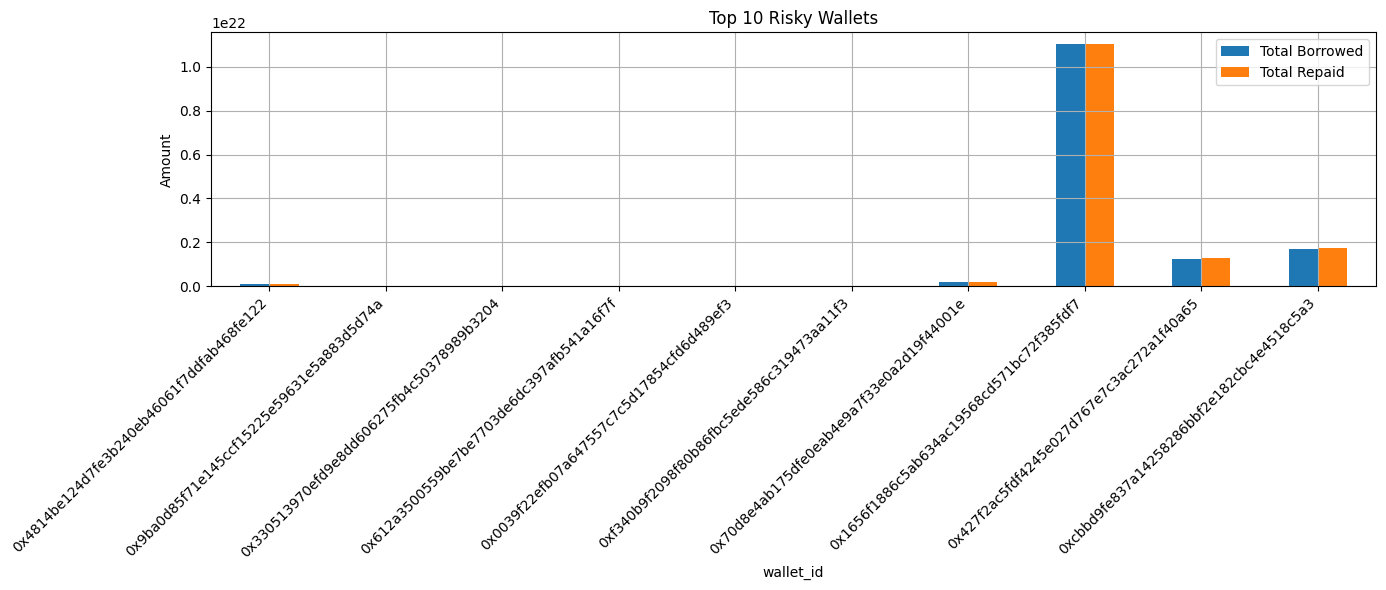

In [61]:
# Calculate risk as borrow - repay
wallet_summary['Net Risk'] = wallet_summary['Total Borrowed'] - wallet_summary['Total Repaid']

# Sort by highest risk
risky_wallets = wallet_summary.sort_values(by='Net Risk', ascending=False).head(10)

# Plot risky wallets
risky_wallets[['Total Borrowed', 'Total Repaid']].plot(kind='bar', figsize=(14, 6), title="Top 10 Risky Wallets")
plt.ylabel("Amount")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()


Step 4: Data Preparation & Feature Engineering

In [62]:
import pandas as pd

df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Group by wallet
wallet_groups = df.groupby('wallet_id')

# Create feature dataframe
feature_df = wallet_groups.agg(
    total_borrowed=('amount', lambda x: x[df.loc[x.index, 'type'] == 'borrow'].sum()),
    total_repaid=('amount', lambda x: x[df.loc[x.index, 'type'] == 'repay'].sum()),
    borrow_count=('type', lambda x: (x == 'borrow').sum()),
    repay_count=('type', lambda x: (x == 'repay').sum()),
    avg_borrow_amount=('amount', lambda x: x[df.loc[x.index, 'type'] == 'borrow'].mean()),
    avg_repay_amount=('amount', lambda x: x[df.loc[x.index, 'type'] == 'repay'].mean()),
    first_activity_date=('timestamp', 'min'),
    last_activity_date=('timestamp', 'max')
).fillna(0)

# Derived features
feature_df['active_days'] = (feature_df['last_activity_date'] - feature_df['first_activity_date']).dt.days + 1
feature_df['borrow_frequency'] = feature_df['borrow_count'] / feature_df['active_days']
feature_df['repay_frequency'] = feature_df['repay_count'] / feature_df['active_days']
feature_df['net_balance'] = feature_df['total_borrowed'] - feature_df['total_repaid']
feature_df['repay_to_borrow_ratio'] = feature_df['total_repaid'] / feature_df['total_borrowed'].replace(0, 1)
feature_df['is_risky'] = ((feature_df['repay_to_borrow_ratio'] < 0.5) & (feature_df['net_balance'] > 0)).astype(int)

# Reset index for further use
feature_df = feature_df.reset_index()

# Show final engineered features
feature_df.head()


,wallet_id,total_borrowed,total_repaid,borrow_count,repay_count,avg_borrow_amount,avg_repay_amount,first_activity_date,last_activity_date,active_days,borrow_frequency,repay_frequency,net_balance,repay_to_borrow_ratio,is_risky
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,6.000000e+09,6.022232e+09,1,1,6.000000e+09,6.022232e+09,2019-09-02 19:29:55,2019-09-14 05:49:21,12,0.083333,0.083333,-2.223179e+07,1.003705,0
1,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,1.101560e+22,1.101616e+22,16,18,6.884750e+20,6.120092e+20,2021-02-20 09:18:06,2021-06-10 14:20:15,111,0.144144,0.162162,-5.647031e+17,1.000051,0
2,0x330513970efd9e8dd606275fb4c50378989b3204,1.670000e+07,1.670000e+07,3,3,5.566667e+06,5.566667e+06,2019-09-01 07:53:09,2019-09-03 07:41:27,2,1.500000,1.500000,0.000000e+00,1.000000,0
3,0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65,1.261000e+21,1.268856e+21,7,5,1.801429e+20,2.537712e+20,2019-12-13 22:46:26,2023-03-18 23:10:47,1192,0.005872,0.004195,-7.855995e+18,1.006230,0
4,0x4814be124d7fe3b240eb46061f7ddfab468fe122,1.197283e+20,1.125115e+20,12,10,9.977355e+18,1.125115e+19,2020-10-29 03:46:28,2020-12-13 01:50:22,45,0.266667,0.222222,7.216786e+18,0.939724,0


In [ ]:
#Here I am again writhing code for converting few columns from exponential to human readable format

In [65]:
import pandas as pd

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Group by wallet
wallet_groups = df.groupby('wallet_id')

# Create feature dataframe
feature_df = wallet_groups.agg(
    total_borrowed=('amount', lambda x: x[df.loc[x.index, 'type'] == 'borrow'].sum()),
    total_repaid=('amount', lambda x: x[df.loc[x.index, 'type'] == 'repay'].sum()),
    borrow_count=('type', lambda x: (x == 'borrow').sum()),
    repay_count=('type', lambda x: (x == 'repay').sum()),
    avg_borrow_amount=('amount', lambda x: x[df.loc[x.index, 'type'] == 'borrow'].mean()),
    avg_repay_amount=('amount', lambda x: x[df.loc[x.index, 'type'] == 'repay'].mean()),
    first_activity_date=('timestamp', 'min'),
    last_activity_date=('timestamp', 'max')
).fillna(0)

# Derived features
feature_df['active_days'] = (feature_df['last_activity_date'] - feature_df['first_activity_date']).dt.days + 1
feature_df['borrow_frequency'] = feature_df['borrow_count'] / feature_df['active_days']
feature_df['repay_frequency'] = feature_df['repay_count'] / feature_df['active_days']
feature_df['net_balance'] = feature_df['total_borrowed'] - feature_df['total_repaid']
feature_df['repay_to_borrow_ratio'] = feature_df['total_repaid'] / feature_df['total_borrowed'].replace(0, 1)
feature_df['is_risky'] = ((feature_df['repay_to_borrow_ratio'] < 0.5) & (feature_df['net_balance'] > 0)).astype(int)

# Function to convert large numbers into human-readable format
def readable_format(x):
    if abs(x) >= 1e9:
        return f'{x/1e9:.2f}B'
    elif abs(x) >= 1e6:
        return f'{x/1e6:.2f}M'
    elif abs(x) >= 1e3:
        return f'{x/1e3:.2f}K'
    else:
        return f'{x:.2f}'

# Apply formatting to relevant columns for visualization
for col in ['total_borrowed', 'total_repaid', 'net_balance', 'avg_borrow_amount', 'avg_repay_amount']:
    feature_df[f'{col}_readable'] = feature_df[col].apply(readable_format)

# Reset index for final DataFrame
feature_df = feature_df.reset_index()

# Show engineered features with readable values
feature_df.head()


,wallet_id,total_borrowed,total_repaid,borrow_count,repay_count,avg_borrow_amount,avg_repay_amount,first_activity_date,last_activity_date,active_days,borrow_frequency,repay_frequency,net_balance,repay_to_borrow_ratio,is_risky,total_borrowed_readable,total_repaid_readable,net_balance_readable,avg_borrow_amount_readable,avg_repay_amount_readable
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,6.000000e+09,6.022232e+09,1,1,6.000000e+09,6.022232e+09,2019-09-02 19:29:55,2019-09-14 05:49:21,12,0.083333,0.083333,-2.223179e+07,1.003705,0,6.00B,6.02B,-22.23M,6.00B,6.02B
1,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,1.101560e+22,1.101616e+22,16,18,6.884750e+20,6.120092e+20,2021-02-20 09:18:06,2021-06-10 14:20:15,111,0.144144,0.162162,-5.647031e+17,1.000051,0,11015600000094.00B,11016164703191.97B,-564703097.97B,688475000005.88B,612009150177.33B
2,0x330513970efd9e8dd606275fb4c50378989b3204,1.670000e+07,1.670000e+07,3,3,5.566667e+06,5.566667e+06,2019-09-01 07:53:09,2019-09-03 07:41:27,2,1.500000,1.500000,0.000000e+00,1.000000,0,16.70M,16.70M,0.00,5.57M,5.57M
3,0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65,1.261000e+21,1.268856e+21,7,5,1.801429e+20,2.537712e+20,2019-12-13 22:46:26,2023-03-18 23:10:47,1192,0.005872,0.004195,-7.855995e+18,1.006230,0,1261000000000.20B,1268855995159.67B,-7855995159.47B,180142857142.89B,253771199031.93B
4,0x4814be124d7fe3b240eb46061f7ddfab468fe122,1.197283e+20,1.125115e+20,12,10,9.977355e+18,1.125115e+19,2020-10-29 03:46:28,2020-12-13 01:50:22,45,0.266667,0.222222,7.216786e+18,0.939724,0,119728258123.15B,112511471917.31B,7216786205.84B,9977354843.60B,11251147191.73B


Step 5: Feature Normalization & Building Risk Scoring Model

In [66]:
# weights = {
#     'repay_to_borrow_ratio': -0.5,  # higher ratio = safer → negative weight
#     'net_balance': 0.3,             # higher debt = higher risk
#     'borrow_frequency': 0.2,        # frequent borrowing = slightly riskier
#     'is_risky': 0.5                 # strong signal
# }


In [67]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# # Copy the feature_df to avoid overwriting
# scoring_df = feature_df.copy()




,wallet_id,risk_score
7,0x9ba0d85f71e145ccf15225e59631e5a883d5d74a,1000.00
2,0x330513970efd9e8dd606275fb4c50378989b3204,366.80
4,0x4814be124d7fe3b240eb46061f7ddfab468fe122,268.32
1,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,237.06
5,0x612a3500559be7be7703de6dc397afb541a16f7f,233.42


In [ ]:
# # Select features for scoring
# scoring_features = ['repay_to_borrow_ratio', 'net_balance', 'borrow_frequency', 'is_risky']




In [ ]:
# # Normalize selected features using MinMaxScaler
# scaler = MinMaxScaler()
# scoring_df_norm = pd.DataFrame(scaler.fit_transform(scoring_df[scoring_features]),
#                                columns=[f"{col}_norm" for col in scoring_features])


In [ ]:

# # Add normalized columns to original dataframe
# for col in scoring_df_norm.columns:
#     scoring_df[col] = scoring_df_norm[col]

In [ ]:
# Assign weights to each normalized feature
weights = {
    'repay_to_borrow_ratio_norm': -0.5,   # lower ratio = riskier
    'net_balance_norm': 0.3,              # more unpaid = riskier
    'borrow_frequency_norm': 0.2,         # frequent = slightly riskier
    'is_risky_norm': 0.5                  # boolean flag
}




In [ ]:
# Compute weighted score
scoring_df['raw_score'] = (
    weights['repay_to_borrow_ratio_norm'] * scoring_df['repay_to_borrow_ratio_norm'] +
    weights['net_balance_norm'] * scoring_df['net_balance_norm'] +
    weights['borrow_frequency_norm'] * scoring_df['borrow_frequency_norm'] +
    weights['is_risky_norm'] * scoring_df['is_risky']
)



In [ ]:
# Normalize raw_score to 0–1000 range
min_score = scoring_df['raw_score'].min()
max_score = scoring_df['raw_score'].max()



In [ ]:
scoring_df['risk_score'] = ((scoring_df['raw_score'] - min_score) / (max_score - min_score)) * 1000
scoring_df['risk_score'] = scoring_df['risk_score'].round(2)



In [ ]:
# Final output
final_wallet_risk = scoring_df[['wallet_id', 'risk_score']].sort_values(by='risk_score', ascending=False)
final_wallet_risk.head()

In [70]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Copy the feature_df to avoid overwriting
scoring_df = feature_df.copy()

# Select features for scoring
scoring_features = ['repay_to_borrow_ratio', 'net_balance', 'borrow_frequency', 'is_risky']




,wallet_id,risk_score
7,0x9ba0d85f71e145ccf15225e59631e5a883d5d74a,1000.00
2,0x330513970efd9e8dd606275fb4c50378989b3204,366.80
4,0x4814be124d7fe3b240eb46061f7ddfab468fe122,268.32
1,0x1656f1886c5ab634ac19568cd571bc72f385fdf7,237.06
5,0x612a3500559be7be7703de6dc397afb541a16f7f,233.42
0,0x0039f22efb07a647557c7c5d17854cfd6d489ef3,230.06
10,0xf340b9f2098f80b86fbc5ede586c319473aa11f3,229.98
6,0x70d8e4ab175dfe0eab4e9a7f33e0a2d19f44001e,227.68
3,0x427f2ac5fdf4245e027d767e7c3ac272a1f40a65,221.81
9,0xcbbd9fe837a14258286bbf2e182cbc4e4518c5a3,215.45


In [ ]:
# Normalize selected features using MinMaxScaler
scaler = MinMaxScaler()
scoring_df_norm = pd.DataFrame(scaler.fit_transform(scoring_df[scoring_features]),
                               columns=[f"{col}_norm" for col in scoring_features])

# Add normalized columns to scoring_df
for col in scoring_df_norm.columns:
    scoring_df[col] = scoring_df_norm[col]






In [ ]:
# Assign weights to each normalized feature
weights = {
    'repay_to_borrow_ratio_norm': -0.5,   # lower = riskier
    'net_balance_norm': 0.3,
    'borrow_frequency_norm': 0.2,
    'is_risky_norm': 0.5
}



In [ ]:
# Compute weighted raw score
scoring_df['raw_score'] = (
    weights['repay_to_borrow_ratio_norm'] * scoring_df['repay_to_borrow_ratio_norm'] +
    weights['net_balance_norm'] * scoring_df['net_balance_norm'] +
    weights['borrow_frequency_norm'] * scoring_df['borrow_frequency_norm'] +
    weights['is_risky_norm'] * scoring_df['is_risky']  # is_risky already 0/1, no need to normalize again
)



In [ ]:
# Normalize raw_score to range 0–1000
min_score = scoring_df['raw_score'].min()
max_score = scoring_df['raw_score'].max()
scoring_df['risk_score'] = ((scoring_df['raw_score'] - min_score) / (max_score - min_score)) * 1000
scoring_df['risk_score'] = scoring_df['risk_score'].round(2)


In [ ]:
# Display all 103 wallets sorted by risk
final_wallet_risk = scoring_df[['wallet_id', 'risk_score']].sort_values(by='risk_score', ascending=False)

# Show all rows
pd.set_option('display.max_rows', None)
display(final_wallet_risk)

In [75]:
import pandas as pd


scoring_df.to_csv("wallet_risk_scores.csv", index=False)